In [1]:
%pylab inline
import nengo
from nengo.dists import Uniform
import numpy as np
import matplotlib.pyplot as plt
from nengolib import Lowpass, DoubleExp
from nengolib.synapses import ss2sim
from nengolib.signal import LinearSystem, cont2discrete

Populating the interactive namespace from numpy and matplotlib


## Simple harmonic oscillator

In [2]:
def goSHO(
    n_neurons,
    max_rates,
    intercepts,
    tauRise=1e-3,
    tauFall=1e-1,
    tKick=0.1,
    tSim=20,
    seed=0,
    w=2*np.pi,
    tTrans=1,
    neuron_type=nengo.LIF(),
    dt=1e-3,
    ):

    # account for finite dt and tau when calculating the A matrix necessary on the recurrent transform
    # see https://forum.nengo.ai/t/oscillator-example/513/2)
    # syn = DoubleExp(tauRise, tauFall)
    syn = (cont2discrete(Lowpass(tauRise), dt=dt) * cont2discrete(Lowpass(tauFall), dt=dt))
    idealA= [[0, w], [-w, 0]]
    dsys = cont2discrete(LinearSystem((idealA, [[1], [0]], [[1, 0]], [[0]])), dt=dt)
    transform = ss2sim(dsys, syn, dt=None).ss[0]

    model = nengo.Network()
    with model:
        stim = nengo.Node(lambda t: [1,0] if t<tKick else [0,0])
        osc = nengo.Ensemble(n_neurons, dimensions=2,
            neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts)
        nengo.Connection(stim, osc, synapse=syn, transform=transform)
        nengo.Connection(osc, osc, synapse=syn, transform=transform)
        osc_p = nengo.Probe(osc, synapse=syn)
        spikes_p = nengo.Probe(osc.neurons, synapse=syn)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(tSim)

    A = sim.data[spikes_p]
    A_settled = A[int(tTrans/dt):]
    gain = sim.data[osc].gain
    bias = sim.data[osc].bias

    fig, ax = plt.subplots(figsize=((6,6)))
    ax.plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
    ax.set(xlim=((-1,1)), ylim=((-1,1)), xticks=((-1,1)), yticks=((-1,1)),
          xlabel=r"$x_1$", ylabel=r"$x_2$")

    fig, ax = plt.subplots(figsize=((12,6)))
    ax.plot(sim.trange(), np.sin(w*sim.trange()), color='k', linewidth=0.5)
    ax.plot(sim.trange(), sim.data[osc_p])
    ax.set(xlabel='time', ylabel=r"$x(t)$",
        ylim=((-1, 1)), yticks=((-1, 1)), xlim=((0, tSim)), xticks=((0, tSim)))
    print(f"gain range: {np.min(gain):.1f} to {np.max(gain):.1f}")
    print(f"bias range: {np.min(bias):.1f} to {np.max(bias):.1f}")
    print(f'observed firing rate range: {np.min(np.max(A_settled, axis=0)):.0f} to {np.max(A_settled):.0f}Hz')

### LIFRate neurons

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 3.4 to 851.5
bias range: -843.0 to 14.9
observed firing rate range: 0 to 378Hz


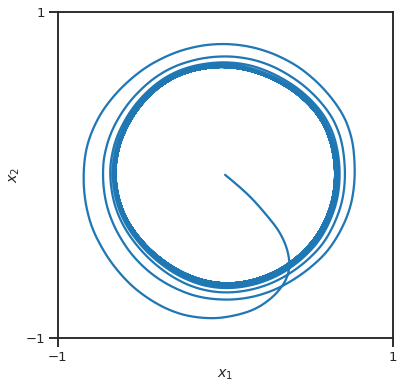

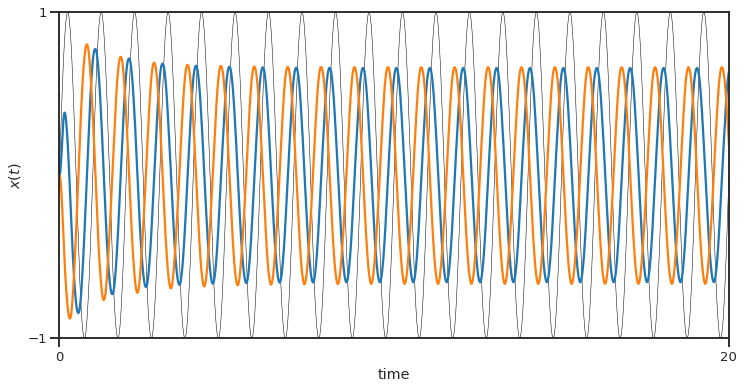

In [25]:
goSHO(100, Uniform(200, 400), Uniform(-1,1), neuron_type=nengo.LIFRate())

Some gains and biases are quite large, but the system is stable and oscillates at the correct frequency. What about lower firing rates?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 6.3
bias range: -4.9 to 1.2
observed firing rate range: 0 to 36Hz


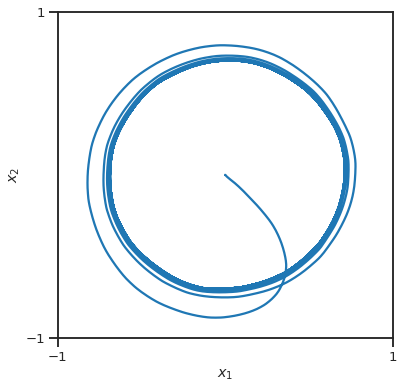

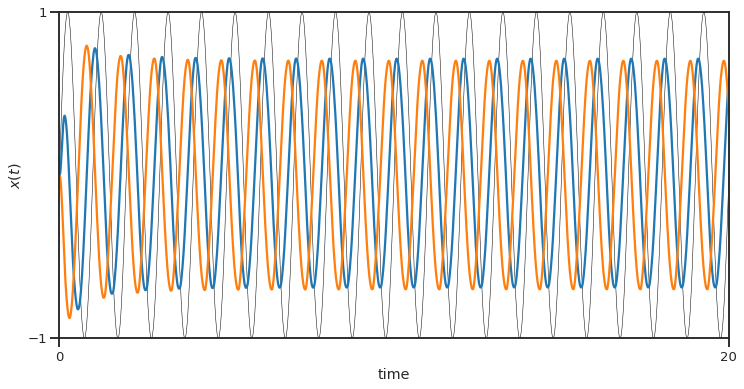

In [26]:
goSHO(100, Uniform(20, 40), Uniform(-1,1), neuron_type=nengo.LIFRate())

Also works quite well. Does shrinking the intercepts make a difference?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 6.0 to 38.2
bias range: -2.6 to 3.8
observed firing rate range: 154 to 349Hz


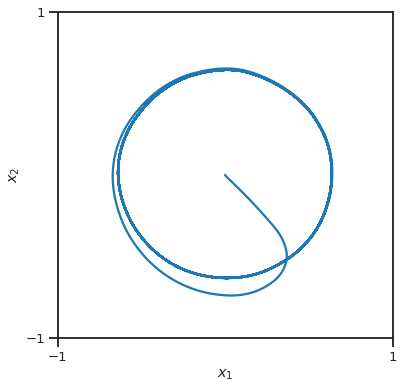

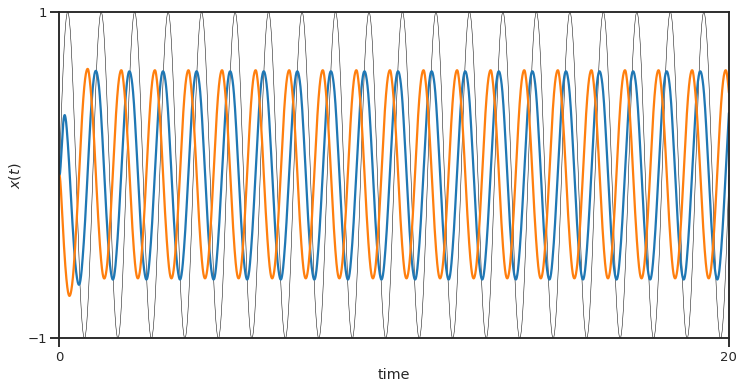

In [27]:
goSHO(100, Uniform(200, 400), Uniform(-0.1,0.1), neuron_type=nengo.LIFRate())

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 0.5
bias range: 1.0 to 1.0
observed firing rate range: 16 to 31Hz


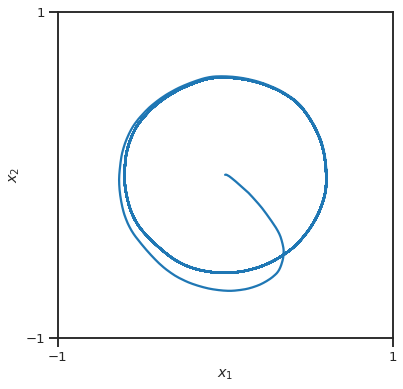

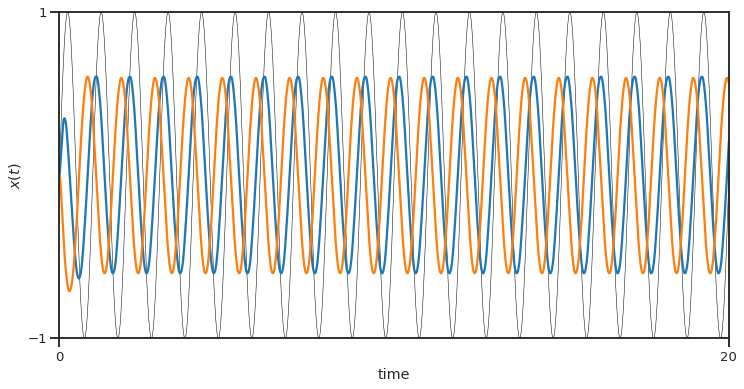

In [28]:
goSHO(100, Uniform(20, 40), Uniform(-0.1,0.1), neuron_type=nengo.LIFRate())

Intercepts make no difference for the system's stability or frequency

### Spiking LIF

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 3.4 to 56697.0
bias range: -56685.5 to 17.9
observed firing rate range: 0 to 379Hz


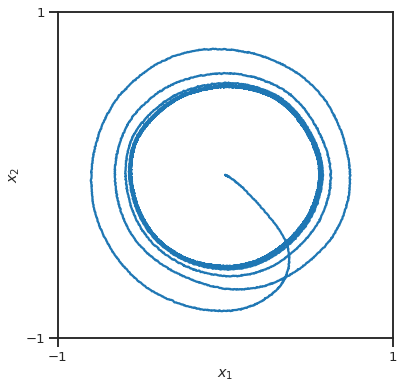

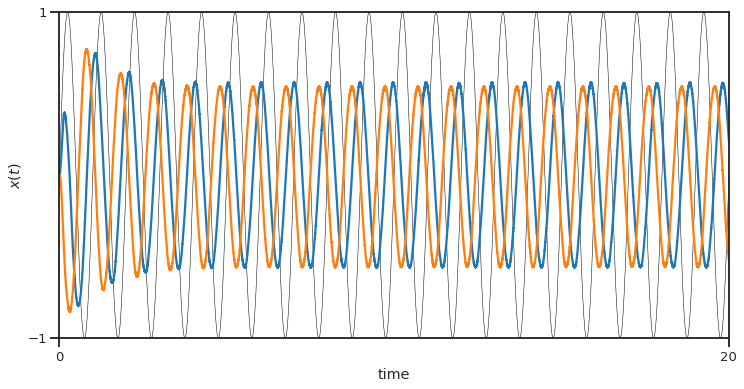

In [29]:
goSHO(100, Uniform(200, 400), Uniform(-1,1))

It's fairly stable. What about with lower firing rates?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 33.0
bias range: -31.8 to 1.2
observed firing rate range: 0 to 36Hz


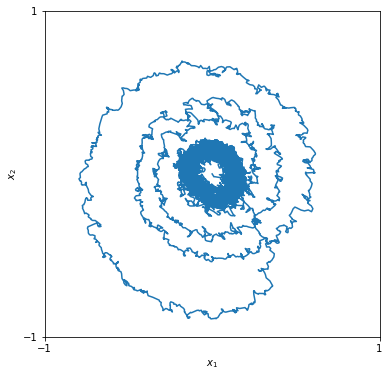

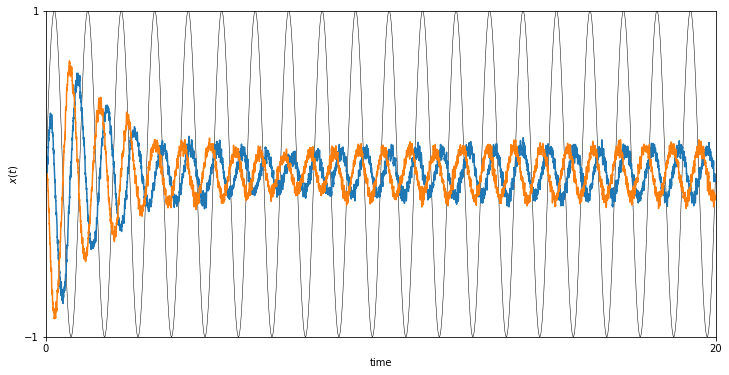

In [4]:
goSHO(100, Uniform(20, 40), Uniform(-1,1))

Not stable enough. More neurons

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 624.0
bias range: -622.8 to 1.2
observed firing rate range: 0 to 37Hz


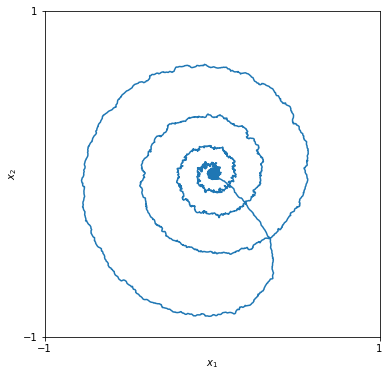

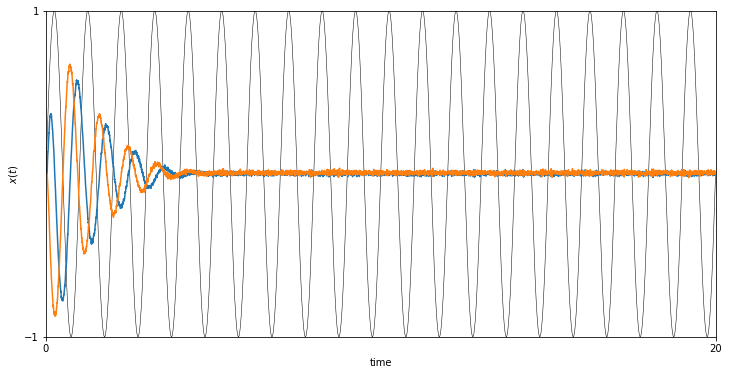

In [5]:
goSHO(1000, Uniform(20, 40), Uniform(-1,1))

Even more neurons?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 1080.5
bias range: -1079.1 to 1.2
observed firing rate range: 0 to 39Hz


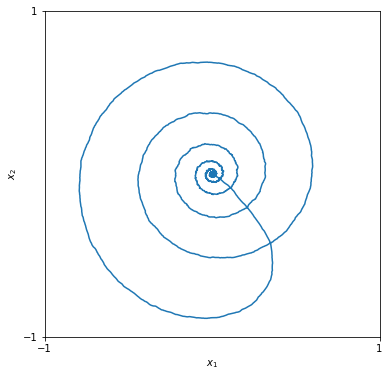

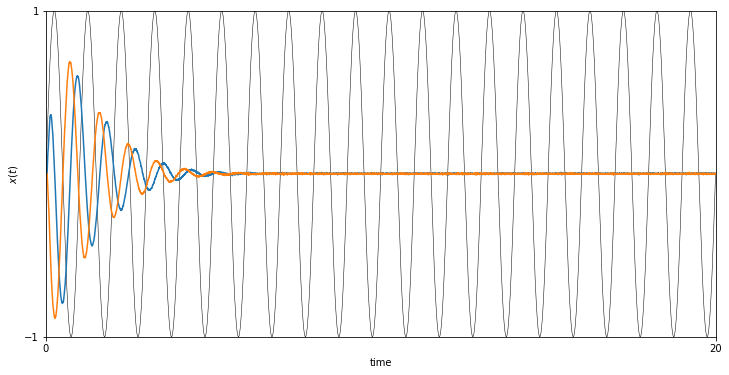

In [6]:
goSHO(10000, Uniform(20, 40), Uniform(-1,1))

It cannot be done :O. What about if we shrink intercepts?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 0.5
bias range: 1.0 to 1.0
observed firing rate range: 20 to 33Hz


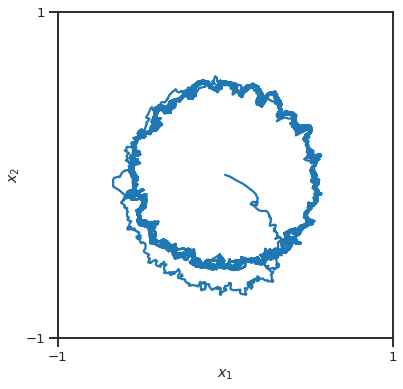

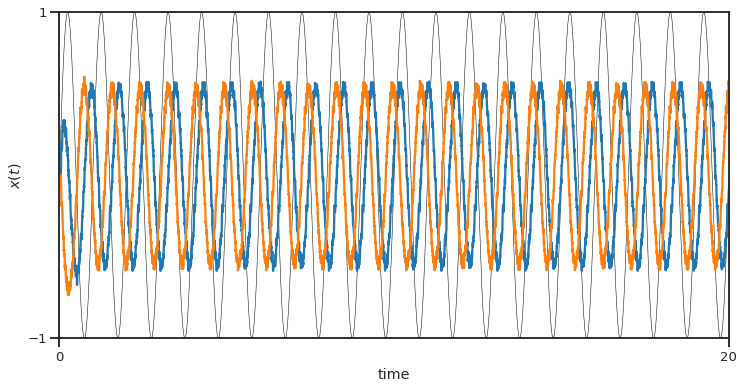

In [31]:
goSHO(100, Uniform(20, 40), Uniform(-0.1,0.1))

Choosing small intercepts improves stability quite a bit! Frequency is a little off, but we only need 100 neurons at 40hz

## Attractive nonlinear oscillator

A SHO:
\begin{align} \frac{d}{dt}
\begin{bmatrix}
x \\ y
\end{bmatrix} &= \begin{bmatrix}
0 & -\omega \\ \omega & 0
\end{bmatrix} \begin{bmatrix}
x \\ y
\end{bmatrix}
\end{align}
So
\begin{align}
\dot{r} &= \frac{x\dot{x} + y\dot{y}}{r} = 0  \\
\dot{\theta} &= \frac{-y\dot{x} + x\dot{y}}{r^2} = \omega
\end{align}
Note that any radius is a fixed point and none are stable.

We could have nonlinear oscillator dynamics though:
\begin{align}
\dot{r} &= f(r)  \\
\dot{\theta} &= \omega
\end{align}
Where $f(r)$ is such that $f(1)=0$ so $r=1$ is a fixed point. Can it stable or attracting? 

The Jacobian matrix:
\begin{align} J = \begin{bmatrix}
\frac{df}{dr} & 0 \\ 0 & 0
\end{bmatrix}
\end{align}
Its eignvalues are
\begin{align}
\det{(J(r=1) - \lambda I)} =\begin{vmatrix}
\frac{df}{dr}|_{r=1} - \lambda & 0 \\ 0 & - \lambda
\end{vmatrix} = - (\frac{df}{dr}|_{r=1} - \lambda) \lambda = 0 \\
\lambda = 0, \frac{df}{dr}|_{r=1}
\end{align}
We know
* "if all eigenvalues are negative real numbers or complex numbers with negative real parts then the point is a stable attracting fixed point, and the nearby points converge to it at an exponential rate"
We want $f$ such that
\begin{align}
f(1) &= 0 \\
\text{Re} \left ( \left . \frac{df}{dr} \right |_{r=1} \right ) &< 0 \\
\end{align}
Examples:
\begin{align}
f(r) = 1-r \\
f(r)  = 1-r^2 \\
f(r)  = (1-r^2)/r^2
\end{align}

The dynamics as $(x,y)$
\begin{align} \frac{d}{dt}
\begin{bmatrix}
x \\ y
\end{bmatrix} &= \begin{bmatrix}
\frac{1}{r^2}( rf(r)x - \omega y) \\
\frac{1}{r^2}( rf(r)y - \omega x)
\end{bmatrix} 
\end{align}

### Let's check out the different dynamics

<Figure size 432x288 with 0 Axes>

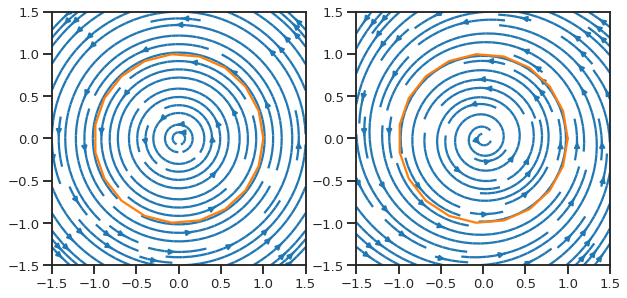

In [10]:
import seaborn as sns
import scipy.linalg


def f1(Y, t):
    y1, y2 = Y
    freq = 2*np.pi
    return [- freq*y2,  freq*y1]

def f2(Y, t):
    y1, y2 = Y
    freq = 2*np.pi
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r) - y2*freq, y2*(1-r) + y1*freq]



y1 = np.linspace(-1.5, 1.5, 10)
y2 = np.linspace(-1.5, 1.5, 10)
Y1, Y2 = np.meshgrid(y1, y2)

t = 0

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]
        

sns.set_style("ticks")
sns.despine()
sns.set_context("talk", font_scale=0.8)

figure(figsize=(10,5))
ax=subplot(1,2,1)
#contourf(Y1,Y2,np.sqrt(u1**2 + v1**2))
streamplot(Y1, Y2, u1, v1)
plot(cos(2*np.pi*np.linspace(0,1,20)),sin(2*np.pi*np.linspace(0,1,20)))
ax.set_aspect('equal')

ax=subplot(1,2,2)
#contourf(Y1,Y2,np.sqrt(u2**2+v2**2))
streamplot(Y1, Y2, u2, v2)
plot(cos(2*np.pi*np.linspace(0,1,20)),sin(2*np.pi*np.linspace(0,1,20)))
ax.set_aspect('equal')

^ comparing SHO to nonlinear one
Here just the direction of flow was shown. Lets consider magnitude too

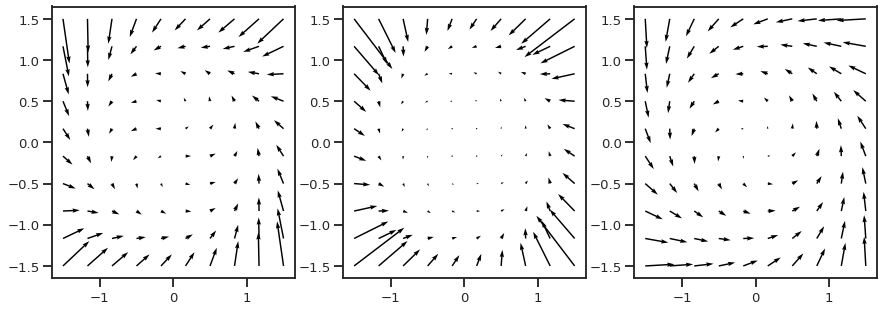

In [11]:
def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r**2)/r - y2*freq, y2*r*(1-r**2)/r + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

figure(figsize=(20,5))
ax=subplot(1,4,1)
quiver(Y1, Y2, u2, v2)


def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*r*(1-r**2) - y2*freq, y2*r*(1-r**2) + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

ax=subplot(1,4,2)
quiver(Y1, Y2, u2, v2)



def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r) - y2*freq, y2*(1-r) + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

ax=subplot(1,4,3)
quiver(Y1, Y2, u2, v2)

## Use the attractive nonlinear oscillator equations on the recurrent connection
This replaces the standard transform for the SHO, and will hopefully impove stability

In [12]:
def goNormal(
    n_neurons,
    max_rates,
    intercepts,
    tauRise=1e-3,
    tauFall=1e-1,
    tKick=0.1,
    tSim=20,
    seed=0,
    w=2*np.pi,
    tTrans=1,
    neuron_type=nengo.LIF(),
    ):

    syn = DoubleExp(tauRise, tauFall)

    def feedback(x):
        r = np.maximum(np.sqrt(x[0]**2 + x[1]**2), 1e-9)
        dx0 = x[0]*(1-r**2)/r - x[1]*w 
        dx1 = x[1]*(1-r**2)/r + x[0]*w 
        return [tauFall*dx0 + x[0],  tauFall*dx1 + x[1]]

    model = nengo.Network()
    with model:
        osc = nengo.Ensemble(n_neurons, dimensions=2, neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts)
        nengo.Connection(osc, osc, function=feedback, synapse=syn)
        osc_p = nengo.Probe(osc, synapse=syn)
        spikes_p = nengo.Probe(osc.neurons, synapse=syn)

    sim = nengo.Simulator(model)
    sim.run(tSim)
    A = sim.data[spikes_p]
    A_settled = A[int(tTrans/0.001):]
    gain = sim.data[osc].gain
    bias = sim.data[osc].bias

    fig, ax = plt.subplots(figsize=((6,6)))
    ax.plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
    ax.set(xlim=((-1,1)), ylim=((-1,1)), xticks=((-1,1)), yticks=((-1,1)),
          xlabel=r"$x_1$", ylabel=r"$x_2$")

    fig, ax = plt.subplots(figsize=((12,6)))
    ax.plot(sim.trange(), np.sin(w*sim.trange()), color='k', linewidth=0.5)
    ax.plot(sim.trange(), sim.data[osc_p])
    ax.set(xlabel='time', ylabel=r"$x(t)$",
        ylim=((-1, 1)), yticks=((-1, 1)), xlim=((0, tSim)), xticks=((0, tSim)))
    print(f"gain range: {np.min(gain):.1f} to {np.max(gain):.1f}")
    print(f"bias range: {np.min(bias):.1f} to {np.max(bias):.1f}")
    print(f'observed firing rate range: {np.min(np.max(A_settled, axis=0)):.0f} to {np.max(A_settled):.0f}Hz')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 4.3 to 5992.2
bias range: -5955.3 to 14.6
observed firing rate range: 0 to 379Hz


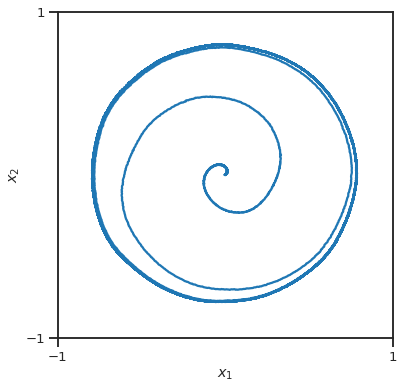

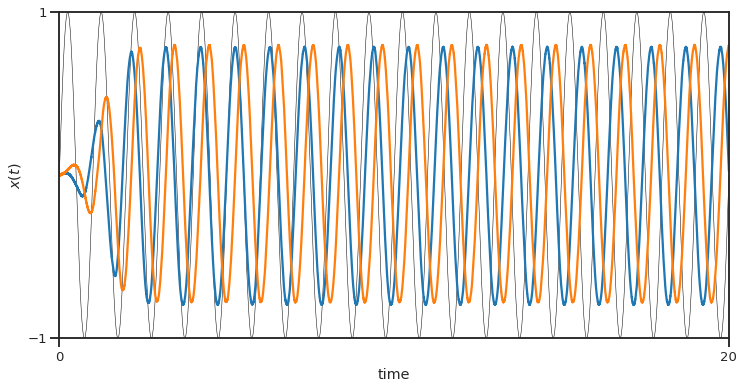

In [13]:
goNormal(100, Uniform(200, 400), Uniform(-1,1))

smaller rates

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 108.8
bias range: -107.5 to 1.2
observed firing rate range: 0 to 39Hz


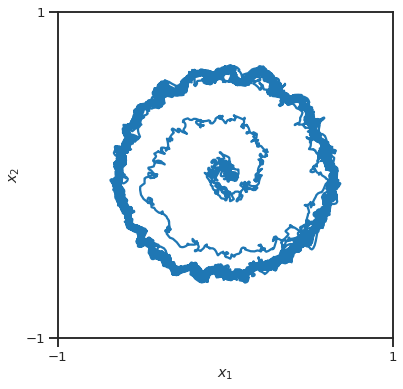

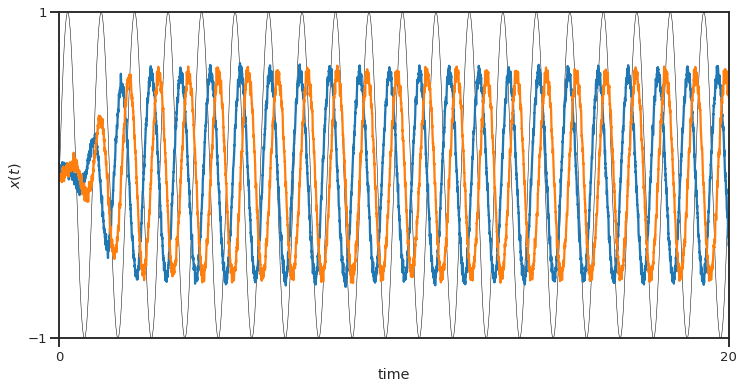

In [14]:
goNormal(100, Uniform(20, 40), Uniform(-1,1))

The frequency is a bit off, but it's stable, unlike the SHO with large intercepts. What about if we use small intercepts?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 5.8 to 38.0
bias range: -1.4 to 3.4
observed firing rate range: 169 to 363Hz


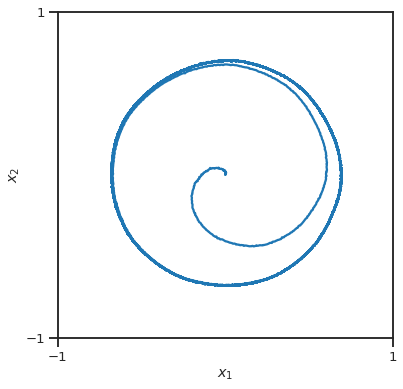

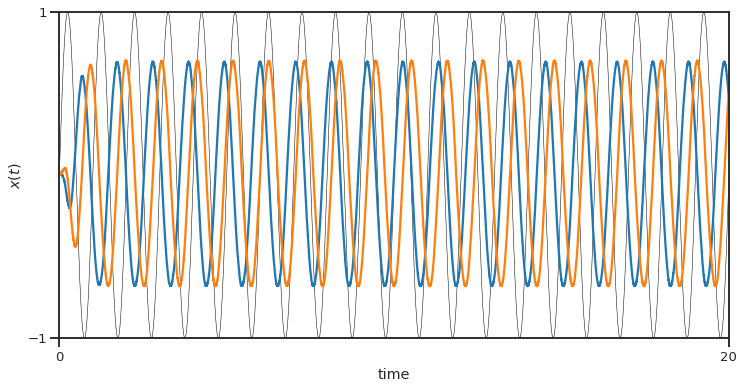

In [15]:
goNormal(100, Uniform(200, 400), Uniform(-0.1,0.1))

small rate and small intercept

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 0.5
bias range: 1.0 to 1.0
observed firing rate range: 22 to 36Hz


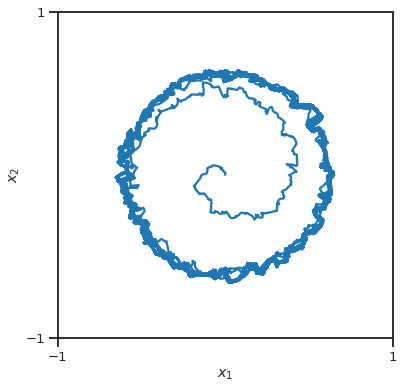

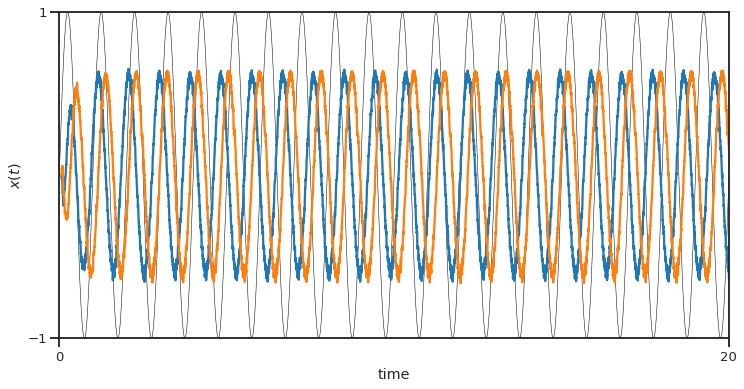

In [16]:
goNormal(100, Uniform(20, 40), Uniform(-0.1,0.1))

Looks good, comparable to the SHO with lower firing rates and small intercepts

## Remove the bias current entirely

A helper function to calculate the gain necessary to achieve max_rate without a bias current
We just solve the LIFRate function to solve for the currents desired to have a maximum rate at $x=1$, given an intercept at $x=0$ (the natural intercept with zero bias)

In [17]:
def getGainLIF(nEns, max_rates):
    neuron = nengo.LIF()
    rates = np.array(max_rates.sample(nEns, rng=np.random.RandomState(seed=0)))
    ints = np.zeros_like(rates)
    bias = np.zeros_like(rates)
    # Solve LIFRate's step_math equation for the input current J required to achieve these rates
    J = 1.0 / (1 - np.exp((neuron.tau_ref - (1.0 / rates)) / neuron.tau_rc))
    # Now assume zero bias, and therefore zero intercept, then
    # compute the gains necessary to achieve these currents
    # J = gain * X + 0, where X is dot(x, e),
    # the dot product between the input vector and the neuron's encoder
    # the maximum firing rate occurs at X=1, so solve for gain
    gain = J
    # test in a small network
    with nengo.Network() as model:
        inpt = nengo.Node(lambda t: np.sin(t))
        # ens = nengo.Ensemble(nEns, 1, neuron_type=neuron, max_rates=rates, intercepts=ints)
        ens = nengo.Ensemble(nEns, 1, neuron_type=neuron, gain=gain, bias=bias)
        nengo.Connection(inpt, ens, synapse=None)
        pX = nengo.Probe(ens, synapse=0.1)
        pA = nengo.Probe(ens.neurons, synapse=0.1)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(10, progress_bar=False)
    A = sim.data[pA]
    print(f'FEEDFORWARD: min-max observed firing rate: {np.min(np.max(A, axis=0)):.0f} - {np.max(A):.0f}Hz')
        
    return gain, bias

Main function

In [18]:
def goNoBias(
    n_neurons,
    max_rates, 
    tauRise=1e-3,
    tauFall=1e-1,
    tKick=0.1,
    tSim=20,
    seed=0,
    w=2*np.pi,
    tTrans=10,
    ):

    syn = DoubleExp(tauRise, tauFall)
    gain, bias = getGainLIF(n_neurons, max_rates)

    def feedback(x):
        r = np.maximum(np.sqrt(x[0]**2 + x[1]**2), 1e-9)
        dx0 = x[0]*(1-r**2)/r - x[1]*w 
        dx1 = x[1]*(1-r**2)/r + x[0]*w 
        return [tauFall*dx0 + x[0],  tauFall*dx1 + x[1]]

    model = nengo.Network()
    with model:
        stim = nengo.Node(lambda t: [1,0] if t<tKick else [0,0])
        osc = nengo.Ensemble(n_neurons, dimensions=2, seed=seed, gain=gain, bias=bias)
        nengo.Connection(stim, osc, synapse=syn)
        nengo.Connection(osc, osc, function=feedback, synapse=syn)
        osc_p = nengo.Probe(osc, synapse=syn)
        spikes_p = nengo.Probe(osc.neurons, synapse=syn)

    sim = nengo.Simulator(model)
    sim.run(tSim)
    A = sim.data[spikes_p]
    A_settled = A[int(tTrans/0.001):]

    fig, ax = plt.subplots(figsize=((6,6)))
    ax.plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
    ax.set(xlim=((-1,1)), ylim=((-1,1)), xticks=((-1,1)), yticks=((-1,1)),
          xlabel=r"$x_1$", ylabel=r"$x_2$")

    fig, ax = plt.subplots(figsize=((12,6)))
    ax.plot(sim.trange(), np.sin(w*sim.trange()), color='k', linewidth=0.5)
    ax.plot(sim.trange(), sim.data[osc_p])
    ax.set(xlabel='time', ylabel=r"$x(t)$",
        ylim=((-1, 1)), yticks=((-1, 1)), xlim=((0, tSim)), xticks=((0, tSim)))
    print(f"gain range: {np.min(gain):.1f} to {np.max(gain):.1f}")
    print(f"bias range: {np.min(bias):.1f} to {np.max(bias):.1f}")
    print(f'observed firing rate range: {np.min(np.max(A_settled, axis=0)):.0f} to {np.max(A_settled):.0f}Hz')

High firing rates

FEEDFORWARD: min-max observed firing rate: 205 - 402Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 7.2 to 39.4
bias range: 0.0 to 0.0
observed firing rate range: 165 to 364Hz


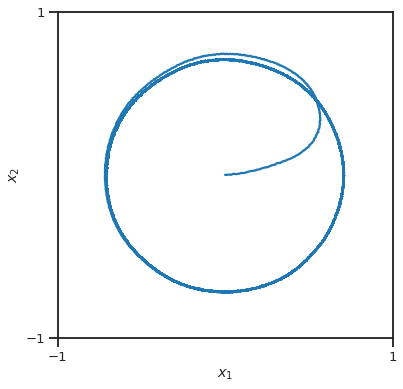

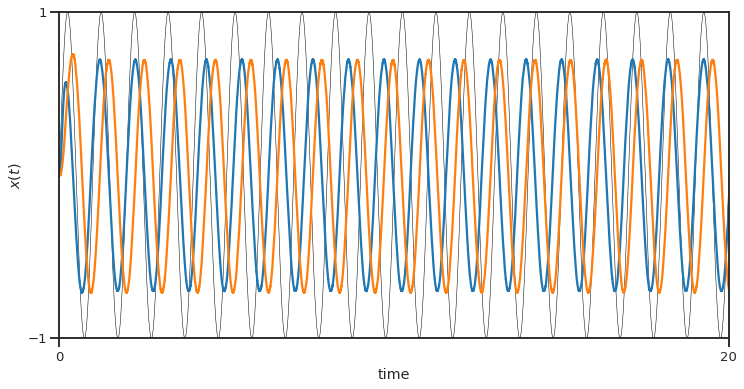

In [19]:
goNoBias(100, nengo.dists.Uniform(200, 400))

Lower firing rates

FEEDFORWARD: min-max observed firing rate: 55 - 104Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 1.7 to 3.0
bias range: 0.0 to 0.0
observed firing rate range: 105 to 176Hz


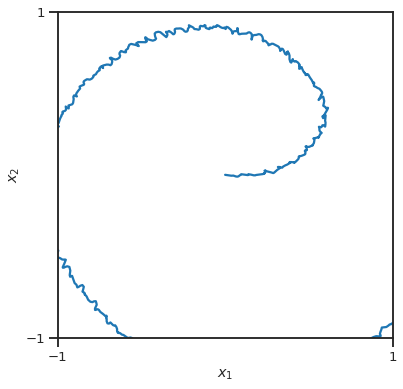

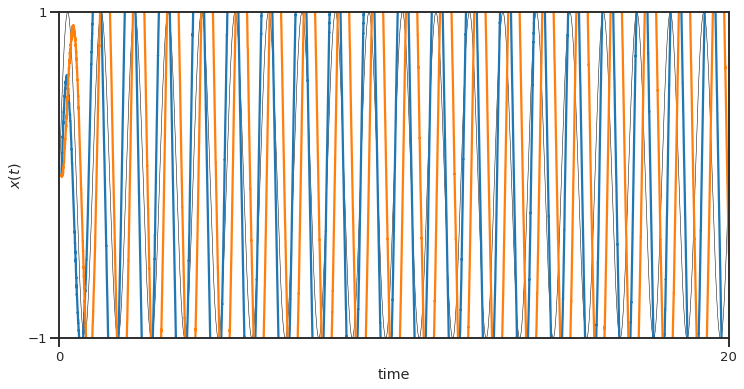

In [20]:
goNoBias(100, nengo.dists.Uniform(50, 100))

The attractor dynamics pulls the neurons out of their preferred firing rate regime to keep the system stable. We'll increase the number of neurons (100 to 500) to try and compensate, so that firing rates remain low throughout

FEEDFORWARD: min-max observed firing rate: 55 - 104Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 1.7 to 3.0
bias range: 0.0 to 0.0
observed firing rate range: 51 to 100Hz


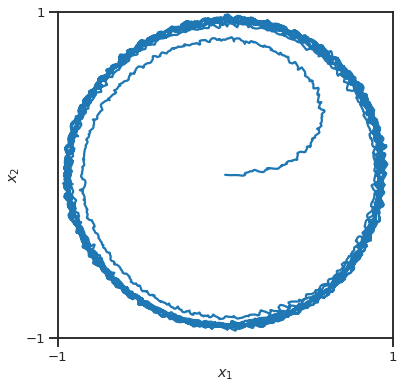

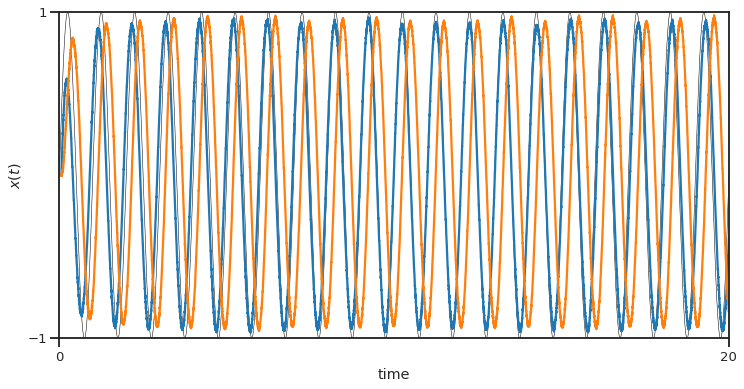

In [21]:
goNoBias(500, nengo.dists.Uniform(50, 100))

This does the trick. Can we get even lower firing rates?

FEEDFORWARD: min-max observed firing rate: 35 - 65Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 1.3 to 1.9
bias range: 0.0 to 0.0
observed firing rate range: 29 to 62Hz


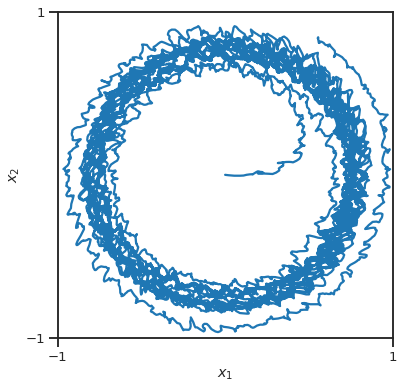

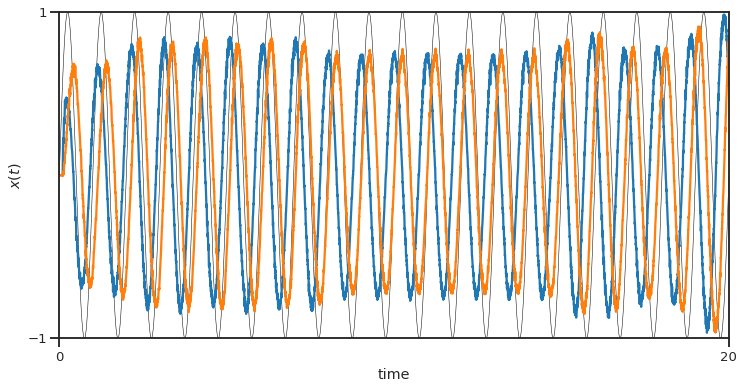

In [22]:
goNoBias(500, nengo.dists.Uniform(30, 60), tKick=0.1)

A little unstable, but still pretty good. More neurons improves stability, and may futher decrease settled firing rates

FEEDFORWARD: min-max observed firing rate: 35 - 65Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 1.3 to 1.9
bias range: 0.0 to 0.0
observed firing rate range: 20 to 50Hz


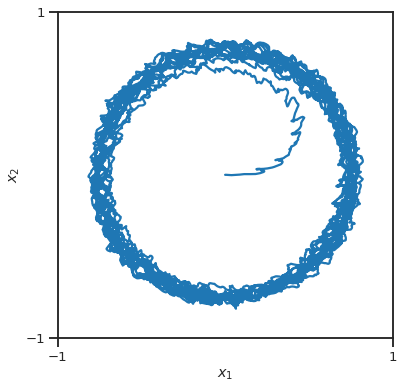

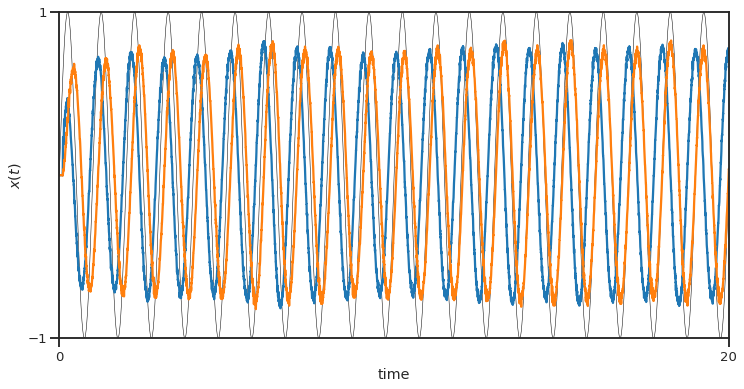

In [23]:
goNoBias(1000, nengo.dists.Uniform(30, 60), tKick=0.1)

Frequency and magnitude are closer to the target dynamics that the SHO or the ANO+biases, but we needed more neurons